In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import shutil
import cv2

Using TensorFlow backend.


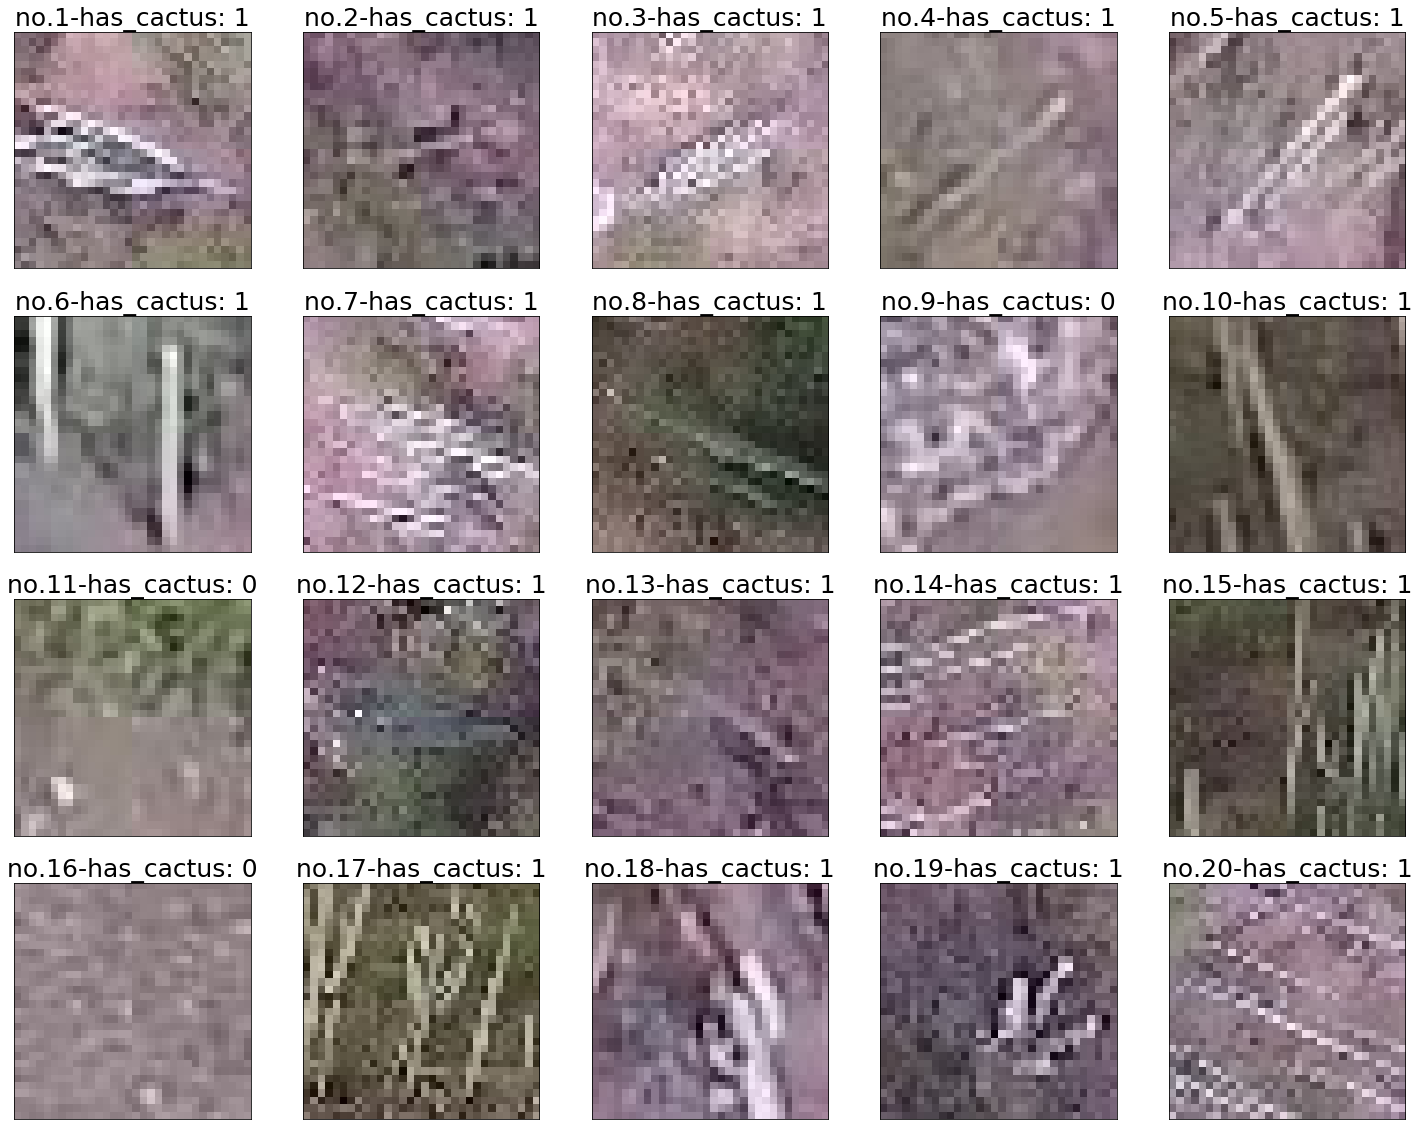

In [23]:
# Display 20 images from dataset
# Images of cactuses labeled as 'has_cactus: 1', ones without cactuses labeled as 'has_catus: 0'

np.random.seed(7)
labels = pd.read_csv('train.csv')
fig = plt.figure(figsize=(25, 20))
images = os.listdir("train")
for imgid, img in enumerate(np.random.choice(images, 20)):
    ax = fig.add_subplot(4, 5, imgid+1, xticks=[], yticks=[])
    im = Image.open("train/" + img)
    plt.imshow(im)
    if labels.loc[labels['id'] == img, 'has_cactus'].values[0] == 1:
        image_label = 'no.' + str(imgid+1) + '-has_cactus: 1'
    else:
        image_label = 'no.' + str(imgid+1) + '-has_cactus: 0'
    ax.set_title(image_label, fontsize=25)

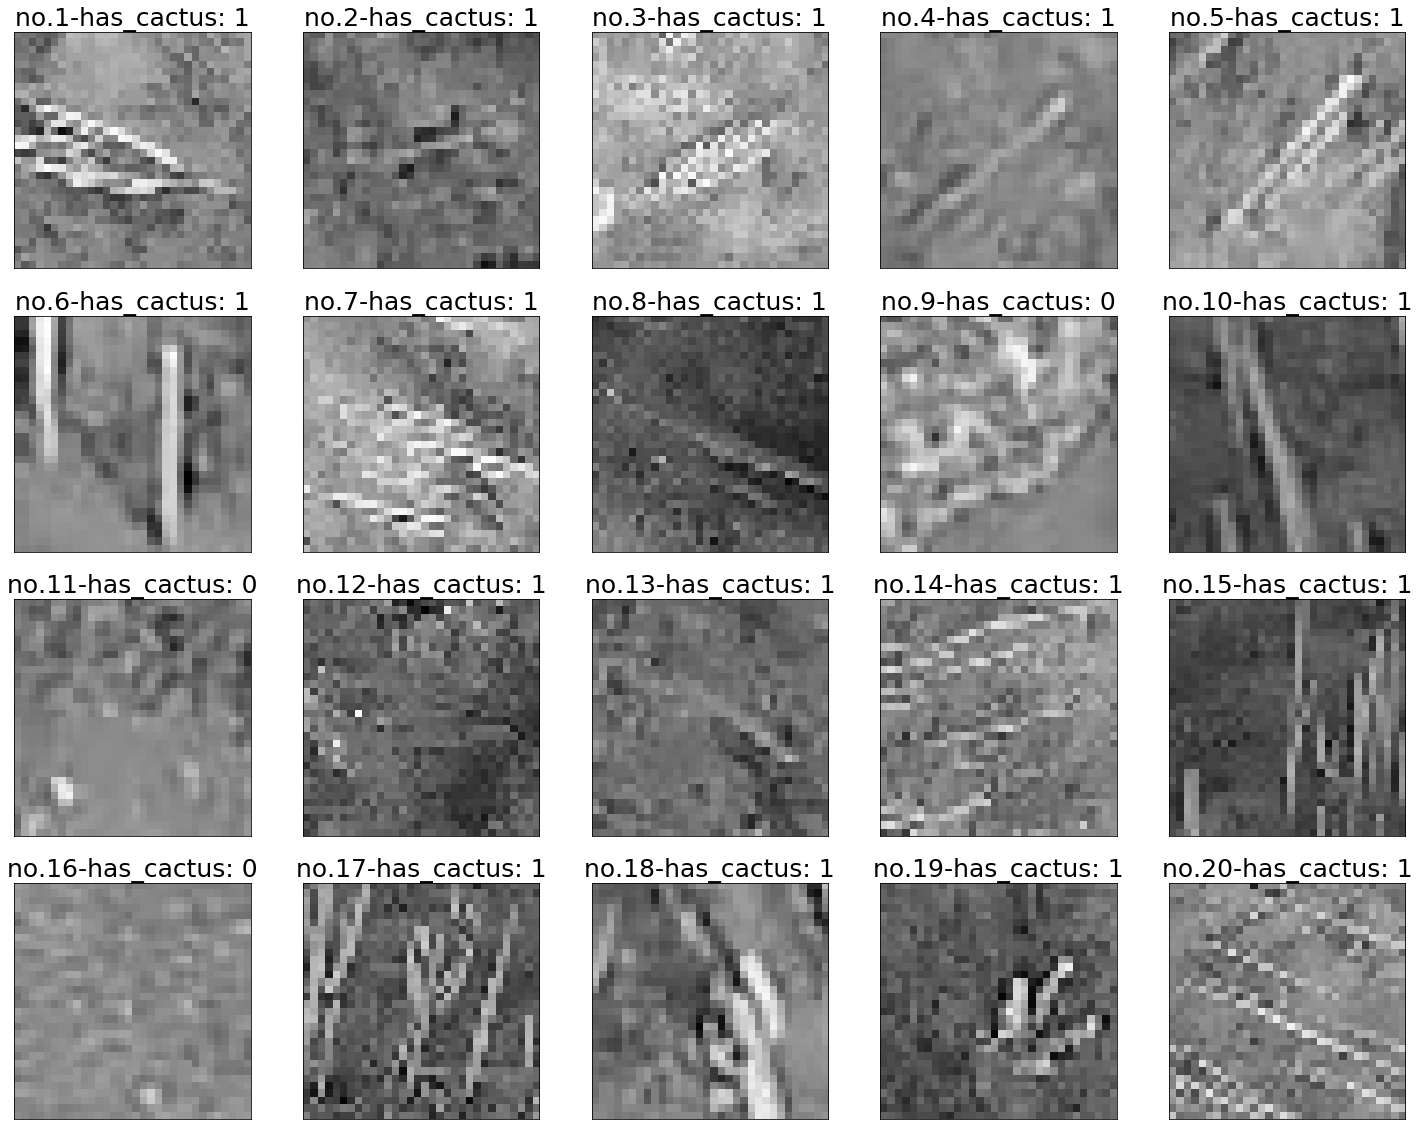

In [24]:
# Display same images from dataset in grayscale.

np.random.seed(7)
fig = plt.figure(figsize=(25, 20))
for imgid, img in enumerate(np.random.choice(images, 20)):
    ax1 = fig.add_subplot(4, 5, imgid+1, xticks=[], yticks=[])
    im = Image.open("train/" + img).convert('LA')
    plt.imshow(im)
    if labels.loc[labels['id'] == img, 'has_cactus'].values[0] == 1:
        image_label = 'no.' + str(imgid+1) + '-has_cactus: 1'
    else:
        image_label = 'no.' + str(imgid+1) + '-has_cactus: 0'
    ax1.set_title(image_label, fontsize=25)

In [25]:
# Display first 15 entries of the csv file with id's of images and labels 'has_cactus'
labels.head(15)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [6]:
#  How many images of each class we have
labels.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [10]:
# Copy images in 2 separate folders: has_cactus_1/ and has_cactus_0/

path_all_1 = 'images/has_cactus_1/'
path_all_0 = 'images/has_cactus_0/'

for img in images:    
    img_location = 'train' + '/' + img
    
    if labels.loc[labels['id'] == img, 'has_cactus'].values[0] == 1:
        shutil.copy(img_location, path_all_1)
    else:
        shutil.copy(img_location, path_all_0)

In [11]:
# Set aside 1313 data samples for testing.

all_1_images = os.listdir(path_all_1)
images_test_1_to_move = list(all_1_images[:1313])

all_0_images = os.listdir(path_all_0)
images_test_0_to_move = list(all_0_images[:1313])

path_test_1 = 'dataset/test/has_cactus_1/'
path_test_0 = 'dataset/test/has_cactus_0/'

for img in images_test_1_to_move:    
    img_location = 'images/has_cactus_1' + '/' + img    
    shutil.move(img_location, path_test_1 + '/' + img)    
    
for img in images_test_0_to_move:    
    img_location = 'images/has_cactus_0' + '/' + img    
    shutil.move(img_location, path_test_0 + '/' + img)

In [13]:
# How many samples left for training and validation

all_1_images = os.listdir(path_all_1)
all_0_images = os.listdir(path_all_0)

print('There are ' + str(len(all_1_images)) + ' images with cactuses')
print('There are ' + str(len(all_0_images)) + ' images without cactuses')

There are 11823 images with cactuses
There are 3051 images without cactuses


In [26]:
# Augmented image genarator function

def aug_img_gen(img, img_folder, dst, prefix):
    aug_datagen = ImageDataGenerator()
    img = cv2.imread(img_folder + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented_img = aug_datagen.apply_transform(img, transform_parameters={'theta':60,
                                                                           'tx':0.3,
                                                                           'ty':0.3,
                                                                           'zx':0.8,
                                                                           'zy':0.8,
                                                                           'flip_vertical':'True',
                                                                          })
    cv2.imwrite(dst + prefix + '.jpg', augmented_img)

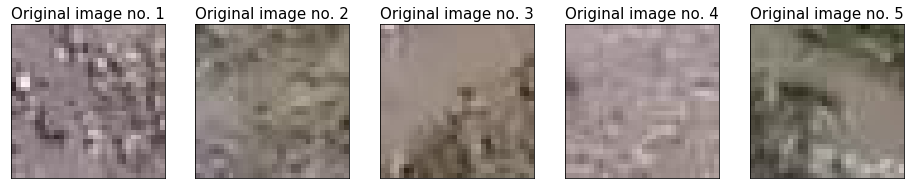

In [34]:
# Testing the image augmentation and displaying results

display_dst = 'display_dst/'
display_prefix = 'display_aug'
display_x = 1

for img in all_0_images[:5]:
    aug_img_gen(img, path_all_0, display_dst, display_prefix + str(display_x))
    display_x += 1
    
fig = plt.figure(figsize=(16, 4))    
for imgid, img in enumerate(all_0_images[:5]):
    ax = fig.add_subplot(1, 5, imgid+1, xticks=[], yticks=[])
    img = Image.open(path_all_0 + img)
    plt.imshow(img)
    image_label = 'Original image no. ' + str(imgid+1)
    ax.set_title(image_label, fontsize=15)

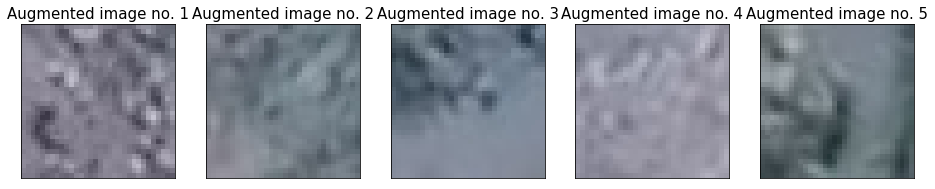

In [37]:
fig = plt.figure(figsize=(16, 4))  
for imgid, img in enumerate(os.listdir(display_dst)):
    ax = fig.add_subplot(1, 5, imgid+1, xticks=[], yticks=[])
    img = Image.open(display_dst + img)
    plt.imshow(img)
    image_label = 'Augmented image no. ' + str(imgid+1)
    ax.set_title(image_label, fontsize=15)

In [39]:
# To balance out images without cactuses we augment them... 

temp_dst = 'images/has_cactus_0_temp/'
prefix = 'aug_img'
i = 1
x = 1

while i < 3:
    for img in all_0_images:
        aug_img_gen(img, path_all_0, temp_dst, prefix + str(x))
        x += 1
    i += 1

for img in all_0_images[:2670]:
    aug_img_gen(img, path_all_0, temp_dst, prefix + str(x))
    x += 1

In [40]:
# ... and put in has_cactus_0/ folder

for img in os.listdir(temp_dst):
    shutil.move(temp_dst + img, path_all_0 + img)

In [2]:
# How many images we have for training and validation now

all_1_images = os.listdir(path_all_1)
all_0_images = os.listdir(path_all_0)

print('There are ' + str(len(all_1_images)) + ' images with cactuses')
print('There are ' + str(len(all_0_images)) + ' images without cactuses')

There are 11823 images with cactuses
There are 11823 images without cactuses


In [3]:
# split remaining dataset into training and validation sets of 90:10 ratio

import split_folders

split_folders.ratio('images', output="dataset", seed=42, ratio=(.9, .1))

In [5]:
# The structure of dataset directories we have now

for dirname, dirnames, filenames in os.walk('dataset'):
    for subdirname in dirnames:
        print(os.path.join(dirname, subdirname))

dataset\test
dataset\train
dataset\val
dataset\test\has_cactus_0
dataset\test\has_cactus_1
dataset\train\has_cactus_0
dataset\train\has_cactus_1
dataset\val\has_cactus_0
dataset\val\has_cactus_1


In [6]:
# Setting up the data for our Benchmark and Transfer Learning models

# dimensions of our images.
img_width, img_height = 32, 32

train_path = 'dataset/train/'
val_path = 'dataset/val/'
test_path = 'dataset/test/'

nb_train_samples = len(os.listdir('dataset/train/has_cactus_1/'))
nb_val_samples = len(os.listdir('dataset/val/has_cactus_1/'))
epochs = 25
batch_size = 32

# We're going to rescale the images to normalize the data
rescale_datagen = ImageDataGenerator(rescale=1. / 255)

train_gen = rescale_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_gen = rescale_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_gen = rescale_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 21280 images belonging to 2 classes.
Found 2366 images belonging to 2 classes.
Found 2626 images belonging to 2 classes.


In [7]:
# Building the benchmark image classification model

benchmark_model = Sequential()
benchmark_model.add(Conv2D(256, 2, input_shape=(32, 32, 3)))
benchmark_model.add(Activation('relu'))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))

benchmark_model.add(Conv2D(128, 2))
benchmark_model.add(Activation('relu'))
benchmark_model.add(Conv2D(64, 2))
benchmark_model.add(Activation('relu'))
benchmark_model.add(Conv2D(32, 2))
benchmark_model.add(Activation('relu'))
benchmark_model.add(Dropout(0.25))

benchmark_model.add(Flatten())
benchmark_model.add(Dense(256))
benchmark_model.add(Activation('relu'))
benchmark_model.add(Dropout(0.50))
benchmark_model.add(Dense(1))
benchmark_model.add(Activation('sigmoid'))

benchmark_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

benchmark_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 31, 256)       3328      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 31, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       131200    
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        32832     
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 64)        0         
__________

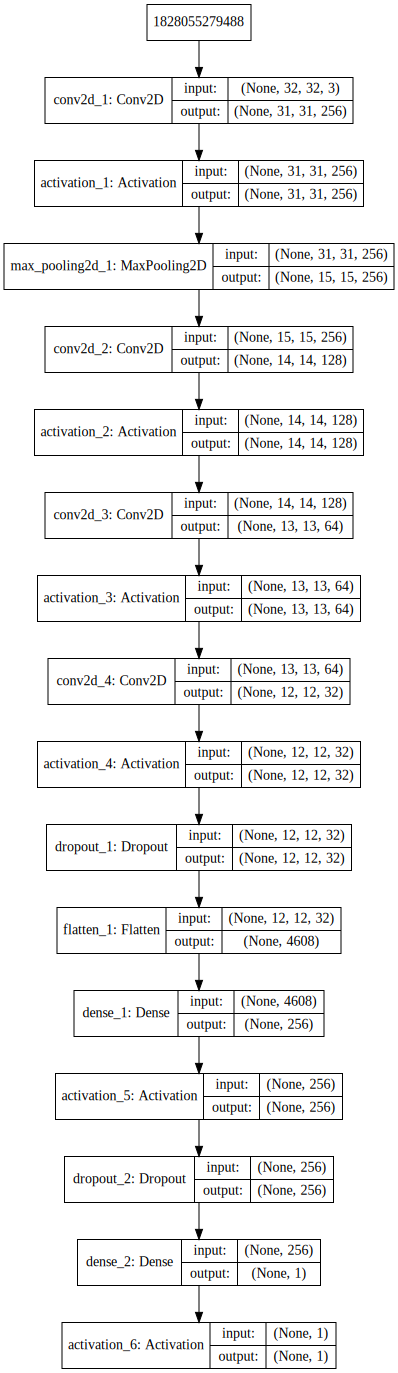

In [22]:
# Visualize the network architecture to image file

import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot as pyd
from keras.utils import plot_model

keras.utils.vis_utils.pydot = pyd

SVG(model_to_dot(benchmark_model, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
# Save the network architecture to image file

plot_model(benchmark_model, show_shapes=True, to_file='benchmark_model_network.png')

In [19]:
# Training the benchmark image classification model

checkpointer = ModelCheckpoint(filepath='benchmark_model_weights.best.hdf5', verbose=1, 
                               save_best_only=True)

history = benchmark_model.fit_generator(
                                        train_gen,
                                        steps_per_epoch=nb_train_samples // batch_size,
                                        epochs=epochs,
                                        validation_data=val_gen,
                                        validation_steps=nb_val_samples // batch_size,
                                        callbacks=[checkpointer], 
                                        verbose=2
                                        )

Epoch 1/25
 - 25s - loss: 0.3266 - acc: 0.8810 - val_loss: 0.0801 - val_acc: 0.9705

Epoch 00001: val_loss improved from inf to 0.08013, saving model to benchmark_model_weights.best.hdf5
Epoch 2/25
 - 6s - loss: 0.1487 - acc: 0.9417 - val_loss: 0.0610 - val_acc: 0.9757

Epoch 00002: val_loss improved from 0.08013 to 0.06103, saving model to benchmark_model_weights.best.hdf5
Epoch 3/25
 - 6s - loss: 0.1164 - acc: 0.9601 - val_loss: 0.0954 - val_acc: 0.9661

Epoch 00003: val_loss did not improve from 0.06103
Epoch 4/25
 - 6s - loss: 0.1105 - acc: 0.9626 - val_loss: 0.0600 - val_acc: 0.9766

Epoch 00004: val_loss improved from 0.06103 to 0.05998, saving model to benchmark_model_weights.best.hdf5
Epoch 5/25
 - 6s - loss: 0.1301 - acc: 0.9609 - val_loss: 0.0637 - val_acc: 0.9774

Epoch 00005: val_loss did not improve from 0.05998
Epoch 6/25
 - 6s - loss: 0.1317 - acc: 0.9623 - val_loss: 3.2711 - val_acc: 0.7066

Epoch 00006: val_loss did not improve from 0.05998
Epoch 7/25
 - 6s - loss: 0.1

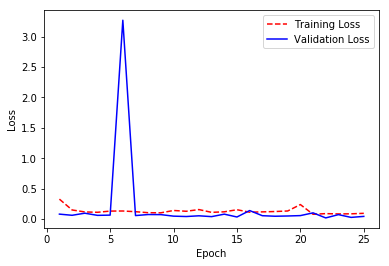

In [28]:
# Plot benchmark network loss history

benchmark_train_loss = history.history['loss']
benchmark_val_loss = history.history['val_loss']

epoch_count = range(1, len(benchmark_train_loss) + 1)

plt.plot(epoch_count, benchmark_train_loss, 'r--')
plt.plot(epoch_count, benchmark_val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

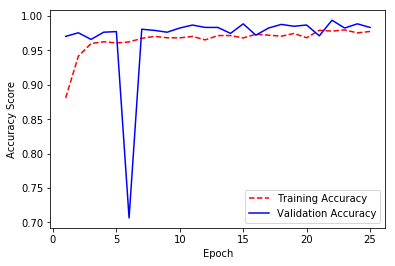

In [29]:
# Plot benchmark network accuracy history

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

epoch_count = range(1, len(train_accuracy) + 1)

plt.plot(epoch_count, train_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

In [21]:
# Testing the benchmark image classification model on samples it has never seen before even in augmented form

benchmark_model.load_weights('benchmark_model_weights.best.hdf5')

score = benchmark_model.evaluate_generator(test_gen, verbose=1, steps=2)
print('\n', 'Benchmark model test accuracy:', score[1])

2/2 [==============================] - 1s 372ms/step

 Benchmark model test accuracy: 0.953125


In [24]:
# Building the VGG16 Transfer Learning image classification model

model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

input = Input(shape=(32, 32, 3),name = 'image_input')
 
output_vgg16_conv = model_vgg16_conv(input)
 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.20)(x)
x = Dense(256, activation='relu', name='fc2')(x)
x = Dropout(0.20)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

tl_model = Model(input=input, output=x)

tl_model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

C:\Users\Asset\Anaconda3\envs\forkeras\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  app.launch_new_instance()


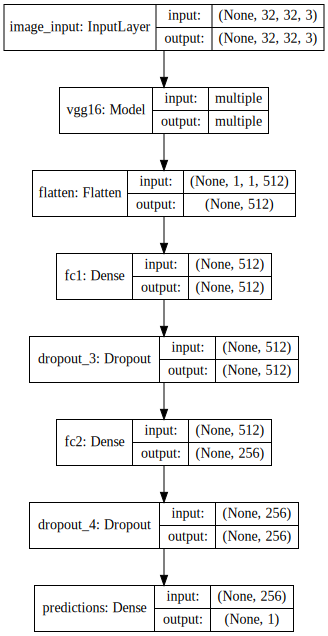

In [25]:
# Visualize the network architecture to image file

SVG(model_to_dot(tl_model, show_shapes=True).create(prog='dot', format='svg'))

In [26]:
# Save the network architecture to image file

plot_model(tl_model, show_shapes=True, to_file='tl_model_network.png')

In [27]:
# Training the VGG16 Transfer Learning image classification model

tl_checkpointer = ModelCheckpoint(filepath='tl_weights.best.hdf5', verbose=1, save_best_only=True)

tl_history = tl_model.fit_generator(train_gen,
                                    steps_per_epoch=nb_train_samples // batch_size,
                                    epochs=epochs,
                                    validation_data=val_gen,
                                    validation_steps=nb_val_samples // batch_size,
                                    callbacks=[tl_checkpointer], 
                                    verbose=2
                                    )

Epoch 1/25
 - 28s - loss: 0.2323 - acc: 0.9114 - val_loss: 0.0418 - val_acc: 0.9852

Epoch 00001: val_loss improved from inf to 0.04183, saving model to tl_weights.best.hdf5
Epoch 2/25
 - 26s - loss: 0.0460 - acc: 0.9832 - val_loss: 0.0217 - val_acc: 0.9913

Epoch 00002: val_loss improved from 0.04183 to 0.02168, saving model to tl_weights.best.hdf5
Epoch 3/25
 - 26s - loss: 0.0577 - acc: 0.9806 - val_loss: 0.0101 - val_acc: 0.9965

Epoch 00003: val_loss improved from 0.02168 to 0.01007, saving model to tl_weights.best.hdf5
Epoch 4/25
 - 26s - loss: 0.0457 - acc: 0.9855 - val_loss: 0.0263 - val_acc: 0.9913

Epoch 00004: val_loss did not improve from 0.01007
Epoch 5/25
 - 26s - loss: 0.0163 - acc: 0.9943 - val_loss: 0.0204 - val_acc: 0.9905

Epoch 00005: val_loss did not improve from 0.01007
Epoch 6/25
 - 26s - loss: 0.0081 - acc: 0.9976 - val_loss: 0.0122 - val_acc: 0.9965

Epoch 00006: val_loss did not improve from 0.01007
Epoch 7/25
 - 26s - loss: 0.0147 - acc: 0.9950 - val_loss: 0.0

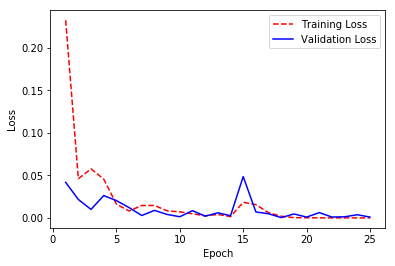

In [32]:
# Plot transfer learning network loss history

tl_train_loss = tl_history.history['loss']
tl_val_loss = tl_history.history['val_loss']

epoch_count = range(1, len(tl_train_loss) + 1)

plt.plot(epoch_count, tl_train_loss, 'r--')
plt.plot(epoch_count, tl_val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

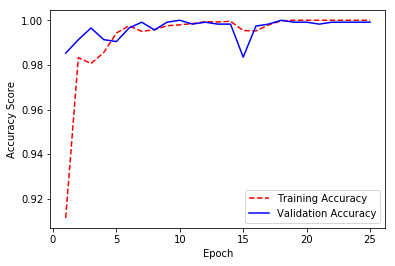

In [33]:
# Plot transfer learning network accuracy history

train_accuracy = tl_history.history['acc']
val_accuracy = tl_history.history['val_acc']

epoch_count = range(1, len(train_accuracy) + 1)

plt.plot(epoch_count, train_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

In [31]:
# Testing the transfer learning image classification model on samples it has never seen before even in augmented form

tl_model.load_weights('tl_weights.best.hdf5')

score = tl_model.evaluate_generator(test_gen, verbose=1, steps=2)
print('\n', 'Transfer Learning model test accuracy:', score[1])

2/2 [==============================] - 1s 402ms/step

 Transfer Learning model test accuracy: 1.0
